In [1]:
import rebound as rb
from matplotlib import pyplot as plt
import celmech as cm
import numpy as np
import sympy as sp
import radvel

In [2]:
#Least squares fit: 
fit_params = [ 2.28513053e+02, 7.27743508e+00, 5.39371890e+04, -1.78110513e-01, 
              -4.66450116e-02, 3.43378023e+02, 1.78603199e+01, 5.40186750e+04,
               1.32165040e-01, 9.73129308e-02, -5.29039776e-01] 

# star mass, g and auday to m/s conversion factor
STAR_MASS = 920  # 920 jupiter masses
G = 2.825e-7  # converting G to jupiter masses, au, and days
AUDAY_MS = 1.731e6  # conversion factor for au/day to m/s

def mass_to_semiamp(planet_mass, star_mass, period, eccentricity, inclination):
    """
    planet mass (jupiter masses) to semi amplitude
    """
    return ((2 * np.pi * G/period) ** (1/3) * (planet_mass * np.sin(inclination) / star_mass ** (2/3)) * (1/np.sqrt(1 - eccentricity ** 2)))

def semiamp_to_mass(semiamp, star_mass, period, eccentricity, inclination):
    """
    semi amplitude to planet mass (jupiter masses)
    """
    return (((2 * np.pi * G/period) ** (-1/3)) * (semiamp / np.sin(inclination)) * np.sqrt(1 - eccentricity ** 2) * (star_mass ** (2/3)))


def get_sim_from_params(params, inclination, integrator, time_base, star_mass = STAR_MASS, auday_ms = AUDAY_MS):
    """
    takes in params array, returns a rebound Simulation object with those parameters
    
    param params: numpy array of params:
    
    for i in range(0, num_planets):
    
    params[i + 0] is period
    params[i + 1] is semiamp
    params[i + 2] is tc (time of conjunction)
    params[i + 3] is sqrt(e) * cos(omega)
    params[i + 4] is sqrt(e) * sin(omega)
    
    params[5 * num_planets] is rv offset
    params[5 * num_planets + 1] is jit
    
    param inclination: inclination of system in the observation plane (pi/2 is in the plane of the sky, 0 is edge-on)
    param integrator: integrator to use, one of 'whfast' or 'ias15'
    param time_base: base time (to begin integration from) in the simulation
    """
    
    num_planets = int((len(params) - 1) / 5) # -2 because there are rv_offset and jit parameters:
    
    sim = rb.Simulation()
    sim.integrator = integrator
    sim.t = time_base  # keplerian and n-body models initialized at the same time offset
    # print(sim.t)
    if integrator == 'whfast':  # if using whfast integrator, set timestep
        sim.dt = 1/50 * min(params[0::5][:-1])  # timestep is 1/20th of the shortest orbital period of any planet
        # print(sim.dt)
    sim.units = ('AU', 'Mjupiter', 'day')

    sim.add(m = star_mass)  # star mass as a constant
        
    for i in range (0, num_planets):
        # print(i)
        # planet parameters
        period = params[5*i]  # in days
        semiamp = params[5*i + 1] / auday_ms # divide by auday_ms because semiamp given in m/s
        eccentricity = params[5*i + 3] ** 2 + params[5*i + 4] ** 2  # eccentricity from secos, sesin
        omega = np.arctan2(params[5*i + 3], params[5*i + 4])  # omega from arctan of sesin, secos
        # get tp by converting from tc
        tp = radvel.orbit.timetrans_to_timeperi(params[5*i + 2], per = period, ecc = eccentricity, omega = omega)
        
        # mass
        mass = semiamp_to_mass(semiamp = semiamp, star_mass = star_mass, period = period, eccentricity = eccentricity, inclination = inclination)
        
        # adding to simulation
        sim.add(m = mass, P = period, e = eccentricity, T = tp, omega = omega, inc = inclination)
        
    sim.move_to_com()  # move to center of mass
    
    return sim

def get_simple_sim(masses, integrator = 'ias15', period_ratio = 3/2, epsilon=0.01):
    """
    gets simple sim (for eccentricity track stuff)
    param masses: array of planet masses
    param integrator: integrator
    param epsilon: amount by which the resonant period ratio should be offset from the equilibrium in the simulation
    """
    sim = rb.Simulation()
    sim.integrator = integrator
    # central star
    sim.add(m = 1)
    
    sim.add(m = masses[0], P = 1)
    sim.add(m = masses[1], P = period_ratio * (1 + epsilon))

    sim.move_to_com()
    if integrator == 'whfast':
        sim.dt = 1/50 * 1  # dy default use 1/50th of the inner planet's orbital period for the timestep if using whfast
    return sim

In [3]:
# sim=rb.Simulation()
# sim.add(m=1)
# sim.add(m=1e-4,P=1)
# sim.add(m=1e-4,P=1.5)

gsim = get_sim_from_params(fit_params, inclination = np.pi/2, integrator= 'ias15', time_base = 0)

masses = np.array([gsim.particles[1].m, gsim.particles[2].m])/gsim.particles[0].m  # divide by star mass!
sim = get_simple_sim(masses, integrator = 'ias15')

pvars = cm.Poincare.from_Simulation(sim)
pham = cm.PoincareHamiltonian(pvars)

Add MMR terms:

In [4]:
pham.add_MMR_terms(3, 1, max_order = 1, inclinations=False)  # try adding max order up to 3

In [5]:
A = np.eye(pham.N_dof,dtype = int)
A[0,:4] = [-2,3,1,0]
A[1,:4] = [-2,3,0,1]
A[2,:4] = [1,-1,0,0]
A[3,:4] = [-2,3,0,0]
angvars=sp.symbols("theta1,theta2,psi,l,phi1,phi2",real=True)
actions=sp.symbols("p1,p2,Psi,L,Phi1,Phi2",positive=True)
_,_,Psi,L,_,_=actions
ct1 = cm.CanonicalTransformation.from_poincare_angles_matrix(pvars,A,new_qp_pairs=list(zip(angvars,actions)))

'ham1' will be the Hamiltonian in the resonant variables you're used to

In [6]:
ham1=ct1.old_to_new_hamiltonian(pham,do_reduction=True)
ham1.H

                                                                    ____      
  √2⋅C_{(3,-2,-1,0,0,0)}_{1,2})__{(0,0,0,0),(0,0)}(\alpha⋅G⋅m₁⋅m₂⋅╲╱ p₁ ⋅cos(θ
- ────────────────────────────────────────────────────────────────────────────
                              _______________                                 
                            ╲╱ \Lambda_{1,0} ⋅a_{2,0}                         

                                                                       ____   
₁)   √2⋅C_{(3,-2,0,-1,0,0)}_{1,2})__{(0,0,0,0),(0,0)}(\alpha⋅G⋅m₁⋅m₂⋅╲╱ p₂ ⋅co
── - ─────────────────────────────────────────────────────────────────────────
                                 _______________                              
                               ╲╱ \Lambda_{2,0} ⋅a_{2,0}                      

                  2   2   3                    2   2   3        
s(θ₂)            G ⋅M₁ ⋅μ₁                    G ⋅M₂ ⋅μ₂         
───── - ─────────────────────────── - ──────────────────────────
             

'ham2' transforms from polar $(\theta_i,p_i)$ variables to cartesian $(y_i,x_i)$ variables. These are usually more convenient for numerical integration and root-finding

In [7]:
ct2 = cm.CanonicalTransformation.polar_to_cartesian(ham1.full_qp_vars,indices=[0,1])

ham2=ct2.old_to_new_hamiltonian(ham1)
ham2.H

                                                                              
  C_{(3,-2,-1,0,0,0)}_{1,2})__{(0,0,0,0),(0,0)}(\alpha⋅G⋅m₁⋅m₂⋅x₁   C_{(3,-2,0
- ─────────────────────────────────────────────────────────────── - ──────────
                       _______________                                        
                     ╲╱ \Lambda_{1,0} ⋅a_{2,0}                                

                                                                              
,-1,0,0)}_{1,2})__{(0,0,0,0),(0,0)}(\alpha⋅G⋅m₁⋅m₂⋅x₂                         
───────────────────────────────────────────────────── - ──────────────────────
           _______________                                 2                 2
         ╲╱ \Lambda_{2,0} ⋅a_{2,0}                      8⋅L  - 8⋅L⋅Ψ + 8⋅L⋅x₁ 

                                                                            2 
                                                                           G ⋅
──────────────────────────────────────────────────

A composite transformation representing all the transformations so far

In [8]:
ct_all = cm.CanonicalTransformation.composite([ct1,ct2])

In [9]:
oldvars = ct_all.old_qp_vars
_,eta1,_,_,eta2,_,L1,kappa1,_,L2,kappa2,_= oldvars
newvars = ct_all.new_qp_vars
y1,y2,_,_,_,_,x1,x2,Psi,L,_,_ = newvars

Conserved quantities after transformation:

In [10]:
L,ct_all.new_to_old(L)

⎛               2     2     2     2⎞
⎜             η₁    η₂    κ₁    κ₂ ⎟
⎜L, Λ₁ + Λ₂ - ─── - ─── - ─── - ───⎟
⎝              2     2     2     2 ⎠

In [11]:
Psi,ct_all.new_to_old(Psi)

(Ψ, 3⋅Λ₁ + 2⋅Λ₂)

## dissipation
The effect of dissipation, written in terms of the original variables

In [12]:
tau_a1,tau_a2,tau_e1,tau_e2 = sp.symbols("tau_a1,tau_a2,tau_e1,tau_e2")
disflow = sp.Matrix(np.zeros(pham.N_dim))
for hk,tau in zip([(eta1,kappa1),(eta2,kappa2)],(tau_e1,tau_e2)):
    h,k = hk
    disflow[oldvars.index(h)] = -h/tau
    disflow[oldvars.index(k)] = -k/tau
disflow[oldvars.index(L1)] = -L1/tau_a1/sp.S(2)
disflow[oldvars.index(L2)] = -L2/tau_a2/sp.S(2)
disflow

⎡  0  ⎤
⎢     ⎥
⎢-η₁  ⎥
⎢──── ⎥
⎢τₑ₁  ⎥
⎢     ⎥
⎢  0  ⎥
⎢     ⎥
⎢  0  ⎥
⎢     ⎥
⎢-η₂  ⎥
⎢──── ⎥
⎢τₑ₂  ⎥
⎢     ⎥
⎢  0  ⎥
⎢     ⎥
⎢ -Λ₁ ⎥
⎢─────⎥
⎢2⋅τₐ₁⎥
⎢     ⎥
⎢-κ₁  ⎥
⎢──── ⎥
⎢τₑ₁  ⎥
⎢     ⎥
⎢  0  ⎥
⎢     ⎥
⎢ -Λ₂ ⎥
⎢─────⎥
⎢2⋅τₐ₂⎥
⎢     ⎥
⎢-κ₂  ⎥
⎢──── ⎥
⎢τₑ₂  ⎥
⎢     ⎥
⎣  0  ⎦

Define $(D, L_2)$ new variables s.t.
$$
\begin{pmatrix}
L\\
\Psi
\end{pmatrix}
= 
\begin{pmatrix}
-1 & 1+\rho\\
0 & j\rho+(j-1)
\end{pmatrix}
\cdot
\begin{pmatrix}
D\\
L_2
\end{pmatrix}
$$
where $\rho = \left(\frac{\Lambda_1}{\Lambda_2}\right)_\mathrm{res} \approx \frac{m_1}{m_2}\left(\frac{j-1}{j}\right)^{1/3}$.

In terms of old variables,
$$
L = \Lambda_{1} + \Lambda_{2} - \frac{\eta_{1}^{2}}{2} - \frac{\eta_{2}^{2}}{2} - \frac{\kappa_{1}^{2}}{2} - \frac{\kappa_{2}^{2}}{2} = (1 + \rho)L_2 - D\\
\Psi = j \Lambda_{1} + (j-1) \Lambda_{2} = (j\rho+(j-1))L_2~.
$$
In other words, $L_2$ represents the value of $\Lambda_2$ when the planets' instantaneous period ratio is at the exact resonant value and $D$ is the value of $(p_1+p_2)$ when $\Lambda_2 = L_2$.

The planets' period ratio can be expressed in terms of 
$$
\Delta = \frac{j-1}{j}\frac{P_2}{P_1} - 1 \approx 3\left(\frac{\Lambda_2 - L_2}{L_2} - \frac{\Lambda_1 - \rho L_2}{\rho L_2}\right) = 3\frac{\delta\Lambda_2}{L_2}\left(1+\frac{j-1}{j\rho}\right)
$$
where $\delta\Lambda_2 = \Lambda_2 - L_2$

Therefore, we can write 
$$
D = p_1+p_2+(1+\rho)L_2-\Lambda_1 - \Lambda_2
$$
Or
$$
\begin{eqnarray}
D &=& p_1+p_2 - \frac{1}{j}\delta\Lambda_2\\
  &=& p_1+p_2 + \frac{1}{3}\left(\frac{\rho L_2}{j\rho+j-1}\right)\Delta
\end{eqnarray}
$$

The dissipative evolution of $D$ is therefore
$$
\begin{eqnarray}
\dot{D}\big|_\mathrm{dis} &=&-\frac{p_1}{\tau_{e1}}-\frac{p_2}{\tau_{e2}}- \frac{1}{3}\left(\frac{\rho L_2}{j\rho+j-1}\right)\dot{\Delta}\big|_\mathrm{dis}\\
&=&
-\frac{p_1}{\tau_{e1}}-\frac{p_2}{\tau_{e2}}-\frac{1}{2}\left(\frac{\rho L_2}{j\rho+j-1}\right)\frac{1}{\tau_\alpha}
\end{eqnarray}
$$
where I've used $\dot{\Delta}\big|_\mathrm{dis}=\frac{2}{3}\frac{1}{\tau_\alpha}$ with $\tau_\alpha^{-1} = \tau_{a,1}^{-1}- \tau_{a,2}^{-1}$

Convert from $L,\Psi$ to $D,L_2$

In [13]:
D,L2res,rho = sp.symbols("D,L2,rho")
rho_val = (pham.particles[1].m/pham.particles[2].m) * (2/3)**(1/3) 
mtrx = sp.Matrix([[-1,1+rho],[0,3*rho + 2]]) 
D_exprn,L2res_exprn = mtrx.inv() * sp.Matrix([L,Psi])
Dval,L2val = [float(s.subs(ham2.full_qp).subs({rho:rho_val})) for s in (D_exprn,L2res_exprn)]
newvars = [y1,y2,x1,x2,D_exprn]
subsrule = dict(zip([L,Psi],mtrx * sp.Matrix([D,L2res])))


In [14]:
D_exprn

     Ψ⋅(ρ + 1)
-L + ─────────
      3⋅ρ + 2 

 Initial value of $D$

In [15]:
from sympy.simplify.fu import TR10,TR10i,TR11
mtrx_func = lambda i,j: sp.simplify(TR10i(TR10(sp.diff(ct_all.new_to_old(newvars[i]),oldvars[j]))))
jac_old = sp.Matrix(len(newvars),len(oldvars),mtrx_func)
newdisflow = sp.simplify(ct_all.old_to_new(jac_old * disflow))

newdisflow = newdisflow.subs(subsrule)

p1 = (x1*x1 + y1*y1)/sp.S(2)
p2 = (x2*x2 + y2*y2)/sp.S(2)
factor = rho * L2res / (3*rho+2)
tau_alpha = 1/(1/tau_a1 - 1/tau_a2)
Ddot_dis = -1*factor *(1/sp.S(2))* 1/tau_alpha - p1/tau_e1 - p2/tau_e2
newdisflow_approx = sp.Matrix([(newdisflow[i] if i<4 else Ddot_dis) for i in range(5)])

Ddot_dis

                         2     2     2     2
       ⎛   1     1 ⎞   x₂    y₂    x₁    y₁ 
  L₂⋅ρ⋅⎜- ─── + ───⎟   ─── + ───   ─── + ───
       ⎝  τₐ₂   τₐ₁⎠    2     2     2     2 
- ────────────────── - ───────── - ─────────
     2⋅(3⋅ρ + 2)          τₑ₂         τₑ₁   

In [16]:
newdisflow_approx

⎡                    -y₁                     ⎤
⎢                    ────                    ⎥
⎢                    τₑ₁                     ⎥
⎢                                            ⎥
⎢                    -y₂                     ⎥
⎢                    ────                    ⎥
⎢                    τₑ₂                     ⎥
⎢                                            ⎥
⎢                    -x₁                     ⎥
⎢                    ────                    ⎥
⎢                    τₑ₁                     ⎥
⎢                                            ⎥
⎢                    -x₂                     ⎥
⎢                    ────                    ⎥
⎢                    τₑ₂                     ⎥
⎢                                            ⎥
⎢                         2     2     2     2⎥
⎢       ⎛   1     1 ⎞   x₂    y₂    x₁    y₁ ⎥
⎢  L₂⋅ρ⋅⎜- ─── + ───⎟   ─── + ───   ─── + ───⎥
⎢       ⎝  τₐ₂   τₐ₁⎠    2     2     2     2 ⎥
⎢- ────────────────── - ───────── - ─────────⎥
⎣     2⋅(3⋅ρ 

We'll need to substitute the following numerical values into our equations of motion in a few places:

In [17]:
newpars = {L2res:L2val,rho:rho_val}
newpars

{L₂: 0.000381298367157599, ρ: 0.3107034951002157}

conservative flow expressed in term of dynamical variables (need to augment with $\dot{D}=0$)

In [18]:
newflow = ham2.flow.subs(subsrule).subs(ham2.H_params).subs(newpars)

dissipative flow in terms of new dynamical varaibles:

In [19]:
ham2.qp_vars

[y₁, y₂, x₁, x₂]

In [20]:
ham2.flow

⎡                                                                             
⎢  C_{(3,-2,-1,0,0,0)}_{1,2})__{(0,0,0,0),(0,0)}(\alpha⋅G⋅m₁⋅m₂               
⎢- ──────────────────────────────────────────────────────────── - ────────────
⎢                     _______________                                         
⎢                   ╲╱ \Lambda_{1,0} ⋅a_{2,0}                     ⎛   2       
⎢                                                                 ⎝8⋅L  - 8⋅L⋅
⎢                                                                             
⎢                                                                             
⎢  C_{(3,-2,0,-1,0,0)}_{1,2})__{(0,0,0,0),(0,0)}(\alpha⋅G⋅m₁⋅m₂               
⎢- ──────────────────────────────────────────────────────────── - ────────────
⎢                     _______________                                         
⎢                   ╲╱ \Lambda_{2,0} ⋅a_{2,0}                     ⎛   2       
⎢                                                   

In [21]:
def get_tau_alphas(tau_alpha, m_inner, m_outer, period_ratio):
    # use Kepler's third law to compute the ratio of semi-major axes in resonance from the period ratio in resonance
    sma_ratio = period_ratio ** (2/3)  # ratio of outer planet's semi-major axis to inner
    # define matrix A
    A = np.array([[-1, 1],
                 [m_outer, m_inner * sma_ratio]])
    # compute gamma_1 and gamma_2
    gammas = np.matmul(np.linalg.inv(A), np.array([-1/tau_alpha, 0]))
    # gamma = 1/tau
    taus = 1/gammas
    
    return tuple(taus)  # returns (tau_alpha_outer, tau_alpha_inner) as a tuple

In [22]:
# full flow is the conservative flow matrix augmented with Ddot = 0 plus the dissipative flow matrix
fullflow = sp.Matrix(list(newflow) + [0]) + newdisflow_approx.subs(newpars)

taus = [tau_a1,tau_a2,tau_e1,tau_e2]
dyvars = [y1, y2, x1, x2, D]

flow_fn=sp.lambdify(dyvars+taus,fullflow)

jac_fn=sp.lambdify(
    dyvars+taus,
    sp.Matrix(5,5,lambda i,j : sp.diff(fullflow[i],dyvars[j]) )
)

# negative so it works properly
tauvals = list(get_tau_alphas(-50 * 1e3, masses[0], masses[1], period_ratio=3/2)) + [1e3, 1e3]

# tauvals = [-1e5,+1e5,1e3,1e3]
# tauvals, list(get_tau_alphas(-50 * 1e3, masses[0], masses[1], period_ratio=3/2)) + [1e3, 1e3]

In [23]:
from scipy.integrate import solve_ivp

times = np.linspace(0,6e3,200)
f=lambda t,x: flow_fn(*x,*tauvals).reshape(-1)
Df = lambda t,x: jac_fn(*x,*tauvals)
soln=solve_ivp(f,(times[0],times[-1]),[0,0,0,0,float(Dval)],method='Radau',t_eval=times,jac=Df)
# root=newton_solve(f,Df,soln.y.T[-1])

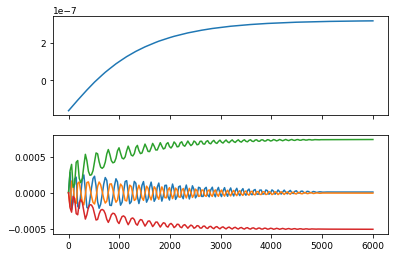

In [24]:
fig,ax= plt.subplots(2,1,sharex=True)
ax[0].plot(times,soln.y[-1])
ax[1].plot(soln.t,soln.y[0])
ax[1].plot(soln.t,soln.y[1])
ax[1].plot(soln.t,soln.y[2])
ax[1].plot(soln.t,soln.y[3])

In [25]:
import warnings
#warnings.filterwarnings("ignore")
from scipy.linalg import solve as lin_solve
def newton_solve(fun,Dfun,guess,max_iter=100,rtol=1e-6,atol=1e-12):
    y = guess.copy()
    for itr in range(max_iter):
        f = fun(y)
        Df = Dfun(y)
        dy = -1 * lin_solve(Df,f)
        y+=dy
        if np.alltrue( np.abs(dy) < rtol * np.abs(y) + atol ):
            break
    else:
        warnings.warn("did not converge")
    return y

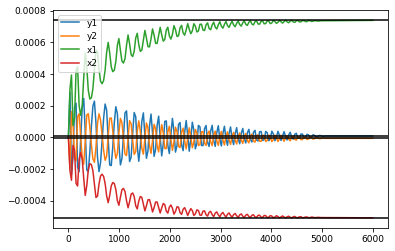

In [26]:
f=lambda x: flow_fn(*x,*tauvals).reshape(-1)
Df = lambda x: jac_fn(*x,*tauvals)
root=newton_solve(f,Df,soln.y.T[-1])

plt.plot(soln.t,soln.y[0], label = 'y1')
plt.plot(soln.t,soln.y[1], label = 'y2')
plt.plot(soln.t,soln.y[2], label= 'x1')
plt.plot(soln.t,soln.y[3], label = 'x2')
for i, r in enumerate(root[:4]):
    plt.axhline(r,color='k')
plt.legend()

In [27]:
tau_alpha_sym, tau_e = sp.symbols('tau_alpha, tau_e')

xydict = dict(zip(dyvars, root))    
# sub with the equilibrium values of d, y1, y2, x1, x2, set ddot = 0 and set tau a1 equal to tau a2
fullflow_N = fullflow.subs(xydict).subs([(-tau_e2, tau_e), (-tau_e1, tau_e)])[4]

# substitute 1/tau_a = 1/tau_a1 - 1/tau_a2 usign the coefficient

ddot_eq = fullflow_N.subs(-fullflow_N.coeff(1/tau_a2)/tau_alpha, -fullflow_N.coeff(1/tau_a2)/tau_alpha_sym)
sp.solve(ddot_eq, tau_alpha_sym)

[50.0⋅τₑ]

In [53]:
tau_a1 in fullflow_N.free_symbols

True

In [58]:
K = sp.symbols('K')

sp.solve(sp.simplify(fullflow_N.subs(tau_a1, 1/(1/tau_alpha_sym + 1/tau_a2)).subs(tau_alpha_sym, K * tau_e)), K)

[50.0]

In [28]:
def D_to_K(flow_mat, root, dyvars=dyvars):
    """
    Computes K = tau_a/tau_e using the flow matrix and its roots
    Flow matrix is zdot = d/dt[y1, y2, x1, x2, D] and settting D_dot to 0    
    """
    tau_alpha_sym, tau_e = sp.symbols('tau_alpha, tau_e')
    # sub with equilibrium values of y1, y2, x1, x2, d, and set tau_e1 = tau_e2 = tau_e
    xydict = dict(zip(dyvars, root))    
    # tau_e1, tau_e2, tau_a1, tau_a2 need to be defined
    flow_mat_N = flow_mat.subs(xydict).subs([(-tau_e2, tau_e), (-tau_e1, tau_e)])[-1]  # D entry is at the end of the matrix
    # substitute 1/tau_a = 1/tau_a1 - 1/tau_a2, attaching the tau_a2 coefficient so sympy recognizes the expression
    ddot_eq = flow_mat_N.subs(-flow_mat_N.coeff(1/tau_a2)/tau_alpha, -flow_mat_N.coeff(1/tau_a2)/tau_alpha_sym)
    # return solving for tau_a in terms of tau_e (coefficient is equal to K)
    K = sp.solve(ddot_eq, tau_alpha_sym)[0].coeff(tau_e)
    return K

In [29]:
Ddot_dis = -1*factor *(1/sp.S(2))* 1/tau_alpha - p1/tau_e1 - p2/tau_e2
newdisflow_approx = sp.Matrix([(newdisflow[i] if i<4 else Ddot_dis) for i in range(5)])
fullflow = sp.Matrix(list(newflow) + [0]) + newdisflow_approx.subs(newpars) 

flow_fn=sp.lambdify(dyvars+taus,fullflow)
jac_fn=sp.lambdify(dyvars+taus, sp.Matrix(5,5,lambda i,j : sp.diff(fullflow[i],dyvars[j])))


In [48]:
fullflow

⎡                                                                             
⎢                                                                             
⎢- ───────────────────────────────────────────────────────────────────────────
⎢                                                                             
⎢  ⎛                           4     2   2     2   2     2   2                
⎢  ⎜                         x₁    x₁ ⋅x₂    x₁ ⋅y₁    x₁ ⋅y₂      2          
⎢  ⎜0.000745339293580541⋅D + ─── + ─────── + ─────── + ─────── + x₁ ⋅(0.000499
⎢  ⎝                          4       2         2         2                   
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢- ───────────────────────────────────────────────────────────────────────────
⎢                                                   

In [30]:
# number of d values
nsims = int(1e2)
# array of roots
roots = np.zeros((nsims, len(dyvars)))

# this is constant, tau_e = tau_e1 = tau_e2
tau_e_val = 1e3

# tau_alpha_vals are K * tau_e_val
tau_alpha_vals = np.logspace(0, 4, nsims) * tau_e_val

from tqdm import tqdm
for i, tau_alpha_val in tqdm(enumerate(tau_alpha_vals)):
    # tau_a1, tau_a2 from tau_a, as well as tau_e1, tau_e2 set to the tau_e_val
    tauvals = list(get_tau_alphas(-tau_alpha_val, masses[0], masses[1], period_ratio=3/2)) + [tau_e_val, tau_e_val]
    f=lambda t,x: flow_fn(*x,*tauvals).reshape(-1)
    Df = lambda t,x: jac_fn(*x,*tauvals)
    soln=solve_ivp(f,(times[0],times[-1]),[0,0,0,0,float(Dval)],method='Radau',t_eval=times,jac=Df)
    f=lambda x: flow_fn(*x,*tauvals).reshape(-1)
    Df = lambda x: jac_fn(*x,*tauvals)
    # record roots
    roots[i] = newton_solve(f,Df,soln.y.T[-1])
    
# for i, D_val in tqdm(enumerate(np.linspace(lb, ub, nds))):
#     f=lambda t,x: flow_fn(*x,*tauvals).reshape(-1)
#     Df = lambda t,x: jac_fn(*x,*tauvals)
#     soln=solve_ivp(f,(times[0],times[-1]),[0,0,0,0,float(D_val)],method='Radau',t_eval=times,jac=Df)
#     f=lambda x: flow_fn(*x,*tauvals).reshape(-1)
#     Df = lambda x: jac_fn(*x,*tauvals)
#     # record roots
#     roots[i] =newton_solve(f,Df,soln.y.T[-1])

100it [07:46,  4.66s/it]


In [31]:
# check to see if these match the Ks
Ks = [D_to_K(fullflow, root) for root in roots]
Ks

[1, 1.09749876549305, 1.20450354025878, 1.32194114846603, 1.45082877849594, 1.
59228279334109, 1.74752840000768, 1.91791026167248, 2.10490414451202, 2.310129
70008316, 2.53536449397011, 2.78255940220712, 3.05385550883342, 3.351602650938
84, 3.67837977182863, 4.03701725859656, 4.43062145758388, 4.86260158006536, 5.
33669923120631, 5.85702081805667, 6.42807311728433, 7.05480231071866, 7.742636
82681128, 8.49753435908644, 9.32603346883218, 10.2353102189903, 11.23324032978
03, 12.3284673944207, 13.5304777457981, 14.8496826225446, 16.2975083462064, 17
.8864952905743, 19.6304065004027, 21.5443469003188, 23.6448941264541, 25.95024
21139974, 28.480358684358, 31.2571584968824, 34.3046928631492, 37.649358067924
7, 41.3201240011534, 45.3487850812858, 49.7702356433211, 54.6227721768435, 59.
9484250318942, 65.7933224657568, 72.2080901838547, 79.2482898353919, 86.974900
2617785, 95.4548456661833, 104.761575278967, 114.975699539774, 126.18568830660
2, 138.488637139387, 151.991108295293, 166.810053720

Get pvars from ham2, the (x, y) Hamiltonian:

In [32]:
ct1.old_qp_vars, ct1.new_qp_vars

([λ₁, η₁, ρ₁, λ₂, η₂, ρ₂, Λ₁, κ₁, σ₁, Λ₂, κ₂, σ₂], [θ₁, θ₂, ψ, l, φ₁, φ₂, p₁, 
p₂, Ψ, L, Φ₁, Φ₂])

In [33]:
[ct1.new_to_old(var) for var in ct1.new_qp_vars]

⎡                                                                             
⎢                                                                             
⎢-2⋅λ₁ + 3⋅λ₂ + atan2(η₁, κ₁), -2⋅λ₁ + 3⋅λ₂ + atan2(η₂, κ₂), λ₁ - λ₂, -2⋅λ₁ + 
⎣                                                                             

                                      2     2    2     2                      
                                    η₁    κ₁   η₂    κ₂                       
3⋅λ₂, atan2(ρ₁, σ₁), atan2(ρ₂, σ₂), ─── + ───, ─── + ───, 3⋅Λ₁ + 2⋅Λ₂, Λ₁ + Λ₂
                                     2     2    2     2                       

     2     2     2     2    2     2    2     2⎤
   η₁    η₂    κ₁    κ₂   ρ₁    σ₁   ρ₂    σ₂ ⎥
 - ─── - ─── - ─── - ───, ─── + ───, ─── + ───⎥
    2     2     2     2    2     2    2     2 ⎦

In [34]:
ham2.full_values, ham2.full_qp_vars

([-1.8387350868967372e-11, 1.1880131114769659e-11, -5.283160433577905e-07, 1.5
849481300733714e-06, -0.0, -0.0, -1.1601231938536712e-05, 7.495596158222382e-0
6, 0.001118008940370812, 0.0004999316896892047, 0.0, 0.0], [y₁, y₂, ψ, l, φ₁, 
φ₂, x₁, x₂, Ψ, L, Φ₁, Φ₂])

In [35]:
e_inner, e_outer = np.zeros(len(roots)), np.zeros(len(roots))

# make a sim to get pvars from:
sim2 = get_simple_sim(masses, integrator = 'ias15')
pvars2 = cm.Poincare.from_Simulation(sim)

# indices of dynamical variables y1, y2, x1, x2
indices = np.array([ct_all.new_qp_vars.index(v) for v in ham2.qp_vars])
# transofmring pvarsfrom old to new values
y0 = ct_all.old_to_new_array(pvars2.values)
    
for i, val in enumerate(roots):
    # for each value, take the 4 dynamical variables y1, y2, x1, and x2 (not including D) and set those as our y0 values
    y0[indices] = val[0:4]
    # then transform all the way from new y, x to old eta, kappa, and then making them pvars
    pvars2.values = ct_all.new_to_old_array(y0)
    # now record the eccentricities
    e_inner[i] = pvars2.particles[1].e
    e_outer[i] = pvars2.particles[2].e

In [36]:
e_inner, e_outer  # Ks increase from 1 to 1000 from the beginning to the end of the array

(array([0.56714002, 0.53257449, 0.50101071, 0.47205956, 0.44539749,
        0.42075431, 0.3979031 , 0.37665196, 0.35683755, 0.33831987,
        0.32097814, 0.3047075 , 0.28941638, 0.27502434, 0.26146031,
        0.24866124, 0.23657084, 0.22513869, 0.2143194 , 0.20407194,
        0.19435911, 0.18514699, 0.17640463, 0.16810365, 0.16021794,
        0.15272346, 0.14559795, 0.13882082, 0.13237292, 0.12623644,
        0.12039475, 0.11483235, 0.10953468, 0.10448814, 0.09967994,
        0.09509805, 0.09073116, 0.08656861, 0.08260032, 0.07881682,
        0.0752091 , 0.07176869, 0.06848753, 0.06535802, 0.06237293,
        0.05952541, 0.05680895, 0.05421739, 0.05174487, 0.0493858 ,
        0.04713489, 0.04498711, 0.04293766, 0.04098197, 0.03911571,
        0.03733473, 0.03563511, 0.0340131 , 0.03246511, 0.03098774,
        0.02957776, 0.02823206, 0.0269477 , 0.02572187, 0.02455189,
        0.0234352 , 0.02236937, 0.02135207, 0.02038108, 0.01945429,
        0.01856968, 0.01772533, 0.01691939, 0.01

In [37]:
nsims = 100
Ks_orig = np.logspace(0, 5, nsims)
ecc_sims_location = 'hd_max_mass'  # folder that the ecc sims are in

e1_track_orig, e2_track_orig = np.zeros(len(Ks_orig)), np.zeros(len(Ks_orig))

for i in range(0, len(Ks_orig)):
    ecc_sim = rb.Simulation(f'{ecc_sims_location}/ecc_track_archive_cluster_{i}.bin')  # get the ith eccentricity simulation from the ecc sims folder
    inner = ecc_sim.particles[1]
    outer = ecc_sim.particles[2]
    
    e1_track_orig[i] = inner.e  # add the e1/e2 values for that simulation
    e2_track_orig[i] = outer.e
    
# 10^1 to 10^2.5

Ks_1025 = np.logspace(1, 2.5, nsims)
ecc_sims_location_1025 = 'hd_eccentricity'  # folder that the ecc sims are in

e1_track_1025, e2_track_1025 = np.zeros(len(Ks_1025)), np.zeros(len(Ks_1025))

for i in range(0, len(Ks_1025)):
    ecc_sim_1025 = rb.Simulation(f'{ecc_sims_location_1025}/ecc_track_archive_cluster_101_1025_{i}.bin')  # get the ith eccentricity simulation from the ecc sims folder
    # print(ecc_sim_1025)
    inner = ecc_sim_1025.particles[1]
    outer = ecc_sim_1025.particles[2]
    e1_track_1025[i] = inner.e  # add the e1/e2 values for that simulation
    e2_track_1025[i] = outer.e

# 10^0 to 10^1
    
Ks_101 = np.logspace(0, 1, nsims)
ecc_sims_location_101 = 'hd_eccentricity'  # folder that the ecc sims are in

e1_track_101, e2_track_101 = np.zeros(len(Ks_101)), np.zeros(len(Ks_101))

for i in range(0, len(Ks_101)):
    ecc_sim_101 = rb.Simulation(f'{ecc_sims_location_101}/ecc_track_archive_cluster_100_101_{i}.bin')  # get the ith eccentricity simulation from the ecc sims folder
    # print(ecc_sim_1025)
    inner = ecc_sim_101.particles[1]
    outer = ecc_sim_101.particles[2]
    e1_track_101[i] = inner.e  # add the e1/e2 values for that simulation
    e2_track_101[i] = outer.e

Ks, e1_track, e2_track = np.concatenate((Ks_orig, Ks_1025, Ks_101)), np.concatenate((e1_track_orig, e1_track_1025, e1_track_101)), np.concatenate((e2_track_orig, e2_track_1025, e2_track_101))

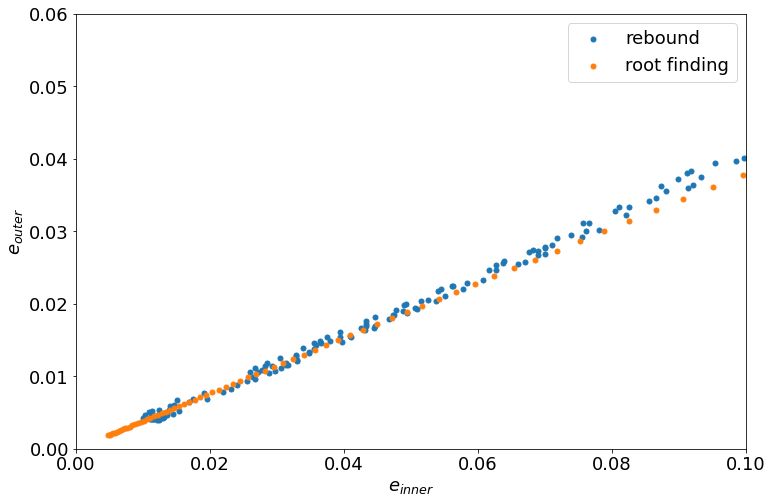

In [46]:
fig = plt.figure(figsize = (12, 8))
ax = fig.add_subplot(111)
plt.rc('font', size=18)  # fontsize larger
# 10^5 annotation
# ax.annotate(fr'$K = 10^5$', xy=(np.delete(e1_track, [1, 2])[np.where(np.delete(Ks, [1, 2]) == 10 ** 5)][0], 
#                                 np.delete(e2_track, [1, 2])[np.where(np.delete(Ks, [1, 2]) == 10 ** 5)][0]), xycoords='data', 
#             textcoords='axes fraction', xytext=(0.1, 0.3), arrowprops=dict(facecolor='red', shrink=0.01), color ='red')
# 10^0 = 1 annotation
# ax.annotate(fr'$K = 1$', xy=(np.delete(e1_track, [1, 2])[np.where(np.delete(Ks, [1, 2]) == 1)][0], 
#                              np.delete(e2_track, [1, 2])[np.where(np.delete(Ks, [1, 2]) == 1)][0]), xycoords='data', 
#             textcoords='axes fraction', xytext=(0.5, 0.95), arrowprops=dict(facecolor='red', shrink=0.01), color ='red')
# pl.scatter(e1_track, e2_track)
plt.scatter(np.delete(e1_track, [1, 2]), np.delete(e2_track, [1, 2]), label = 'rebound')
plt.xlabel(r'$e_{inner}$'), plt.ylabel(r'$e_{outer}$')
# pl.savefig('ecc_track.png', fmt='png')
plt.scatter(e_inner, e_outer, label = 'root finding')
plt.xlim(0, 0.1), plt.ylim(0, 0.06)
plt.legend()
# plt.savefig('order_1.png', fmt='png')
plt.show()

## Converting posterior distributions to D values:

Convert posterior distributions to get a distribution of D values: